Train 16-split models from E30 in isolation, without any pretraining. The accuracy achieved is assumed to be the maximum possible with these architectures.

In [1]:
import sys; sys.path.insert(0, '..')
import utils
import keras
import numpy as np

def embed_and_translate(data, n_width, n_height):
    ndata = np.zeros((len(data), n_width, n_height, 1), dtype='float32')
    translations = np.empty((len(data), 2), dtype='float32')
    width, height = data.shape[1], data.shape[2]
    for i in range(len(data)):
        x = np.random.randint(n_width-width)
        y = np.random.randint(n_height-height)
        ndata[i][x:x+width, y:y+height] = data[i] # rows, cols = height, width
        translations[i][0] = x+(width//2)
        translations[i][1] = y+(height//2)
    return ndata, translations
            
n_splits = 16
output_shape = (56, 56, 1)
input_shape  = (14, 14, 1)
split_x, split_y = 14, 14
latent_dim = 4

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train = x_train.astype('float32') / 255.
x_train_augmented, y_train_regr = embed_and_translate(x_train, output_shape[0], output_shape[1])
x_train_split = np.array([utils.split(x, split_x, split_y) for x in x_train_augmented], dtype='float32')
y_train = keras.utils.to_categorical(y_train)

x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_test = x_test.astype('float32') / 255.
x_test_augmented, y_test_regr = embed_and_translate(x_test, output_shape[0], output_shape[1])
x_test_split = np.array([utils.split(x, split_x, split_y) for x in x_test_augmented], dtype='float32')
y_test = keras.utils.to_categorical(y_test)

1. Sigmoid latent space activation: ~91% accuracy

In [50]:
from keras.layers import Flatten, Conv2D, Conv2DTranspose, Dense, Input, Reshape, concatenate, Activation, Dropout, MaxPooling2D
from keras import Sequential
from keras.models import Model

import tensorflow as tf
import keras
import sys; sys.path.insert(0, '..')
import utils

class MultiSplit(Model):
    def __init__(self, n_splits, latent_dim, input_shape, output_shape):
        super(MultiSplit, self).__init__()
        self.encoder = self._create_encoder(latent_dim, input_shape)
        self.input_reshaper = utils.Reshaper((n_splits, *input_shape), input_shape)
        self.latent_reshaper = utils.Reshaper([latent_dim], [n_splits * latent_dim])
#         self.decoder = self._create_decoder(n_splits * latent_dim, output_shape)
        self.classifier = self._create_classifier(n_splits * latent_dim)
        
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self(x)
            loss = self.compiled_loss(y, y_pred)
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def test_step(self, data):
        x, y = data
        y_pred = self(x, training=False)
        self.compiled_loss(y, y_pred)
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def call(self, x, training=True):
        z = self.encode(x, training=training)
#         y_pred = self.decode(z ,training=training)
        y_pred = self.classify(z ,training=training)
        return y_pred
        
    def encode(self, x, training=True):
        return self.encoder( self.input_reshaper(x) , training)
    
    def decode(self, z, training=True):
        return self.decoder( self.latent_reshaper(z) , training)
    
    def classify(self, z, training=True):
        return self.classifier( self.latent_reshaper(z) , training)
    
    def _create_encoder(self, latent_dim, input_shape, n_filters=[32,64]):
        return Sequential([
            Input(shape=input_shape),
            Conv2D(filters=n_filters[0], kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid'),
            MaxPooling2D((2,2)),
            Conv2D(filters=n_filters[1], kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid'),
            MaxPooling2D((2,2)),
#             Conv2D(filters=1, kernel_size=(1,1), strides=(1,1), activation='relu', padding='valid'),
            Flatten(),
            
#             Dense(units=latent_dim, activation='sigmoid')  #! Sigmoid activation
            Dense(units=latent_dim)  #! Sigmoid activation
        ], name='encoder')

#     def _create_decoder(self, latent_dim, io_shape, n_filters=[32,64]):
#         return Sequential([
#             Input(shape=(latent_dim)),
#             Dense(io_shape[0]//4 * io_shape[1]//4 * 8),  #! Reduce amount of neurons by 4.
#             Reshape((io_shape[0]//4, io_shape[1]//4, 8)),
#             Conv2DTranspose(filters=n_filters[1], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
#             Conv2DTranspose(filters=n_filters[0], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
#             Conv2DTranspose(filters=1, kernel_size=(3,3), padding='same'),
#             Activation('sigmoid', name='decoder_out')
#         ])
    
    def _create_classifier(self, latent_dim):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(256, activation='relu'),
            Dense(128, activation='relu'),
            Dense(64, activation='relu'),
            Dense(10, activation='softmax', name='classifier_out')
        ])

In [51]:
n_splits, latent_dim, input_shape, output_shape = 16, 4, (14,14,1), (56,56,1)
model = MultiSplit(n_splits, latent_dim, input_shape, output_shape)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
print(model.encoder.summary())

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 12, 12, 32)        320       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 4, 4, 64)          18496     
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 2, 2, 64)          0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 256)               0         
_________________________________________________________________
dense_53 (Dense)             (None, 4)                 1028      
Total params: 19,844
Trainable params: 19,844
Non-trainable params: 0
_______________________________________________________

Epoch 1/25
1875/1875 [==============================] - 10s 5ms/step - loss: 0.9185 - acc: 0.6741 - val_loss: 0.5010 - val_acc: 0.8283
Epoch 2/25
1875/1875 [==============================] - 10s 5ms/step - loss: 0.4343 - acc: 0.8548 - val_loss: 0.3798 - val_acc: 0.8752
Epoch 3/25
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3366 - acc: 0.8888 - val_loss: 0.2996 - val_acc: 0.9010
Epoch 4/25
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2808 - acc: 0.9067 - val_loss: 0.2940 - val_acc: 0.9031
Epoch 5/25
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2481 - acc: 0.9180 - val_loss: 0.3430 - val_acc: 0.8911
Epoch 6/25
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2208 - acc: 0.9272 - val_loss: 0.2570 - val_acc: 0.9165
Epoch 7/25
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1990 - acc: 0.9329 - val_loss: 0.2656 - val_acc: 0.9130
Epoch 8/25
1875/1875 [==============================] -

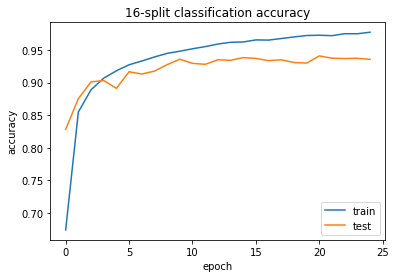

In [52]:
history = model.fit(x_train_split, y_train, validation_data=(x_test_split, y_test), epochs=25, batch_size=32)

import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('16-split classification accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

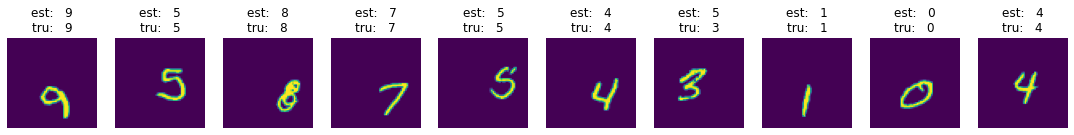

In [53]:
import matplotlib.pyplot as plt
import tensorflow as tf
import random

n = 10
ints = [random.randint(0, len(x_test_split)) for _ in range(n)]
x_inputs = np.array([x_test_split[i] for i in ints], dtype='float32')
y_truths = [y_test[i] for i in ints]
x_truths = [x_test_augmented[i] for i in ints]

z = model.encode(x_inputs, training=False)
y = model.classify(z, training=False)
plt.figure(figsize=(19, 6))
for i in range(n):
    
    plt.subplot(1,n,i+1)
    plt.axis('off')
    plt.title("est: {:3.0f}\ntru: {:3.0f}".format(np.argmax(y[i]), np.argmax(y_truths[i])))
    plt.imshow(x_truths[i].reshape(56,56))

Try reco

In [157]:
model = MultiSplit(n_splits, latent_dim, input_shape, output_shape)
model.compile(loss='mse', optimizer='adam') # COMPILE AFTER WEIGHTS LOADED
# print(model.encoder.summary())
print(model.decoder.summary())

Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_47 (Reshape)         (None, 8, 8, 1)           0         
_________________________________________________________________
conv2d_transpose_42 (Conv2DT (None, 16, 16, 64)        640       
_________________________________________________________________
conv2d_239 (Conv2D)          (None, 16, 16, 32)        18464     
_________________________________________________________________
up_sampling2d_81 (UpSampling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_240 (Conv2D)          (None, 30, 30, 32)        9248      
_________________________________________________________________
up_sampling2d_82 (UpSampling (None, 60, 60, 32)        0         
_________________________________________________________________
conv2d_241 (Conv2D)          (None, 60, 60, 1)       

In [2]:
from keras.layers import Flatten, Conv2D, Conv2DTranspose, Dense, Input, Reshape, concatenate, Activation, Dropout, MaxPooling2D, UpSampling2D
from keras import Sequential
from keras.models import Model

import tensorflow as tf
import keras
import sys; sys.path.insert(0, '..')
import utils

class MultiSplit(Model):
    def __init__(self, n_splits, latent_dim, input_shape, output_shape):
        super(MultiSplit, self).__init__()
        self.encoder = self._create_encoder(latent_dim, input_shape)
        self.input_reshaper = utils.Reshaper((n_splits, *input_shape), input_shape)
        self.latent_reshaper = utils.Reshaper([latent_dim], [n_splits * latent_dim])
        self.decoder = self._create_decoder(n_splits * latent_dim, output_shape)
        self.classifier = self._create_classifier(n_splits * latent_dim)
        
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self(x)
            loss = self.compiled_loss(y, y_pred)
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def test_step(self, data):
        x, y = data
        y_pred = self(x, training=False)
        self.compiled_loss(y, y_pred)
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def call(self, x, training=True):
        z = self.encode(x, training=training)
        y_reco = self.decode(z ,training=training)
        y_class = self.classify(z ,training=training)
        return {"decoder_out": y_reco, "classifier_out": y_class}
        
    def encode(self, x, training=True):
        return self.encoder( self.input_reshaper(x) , training)
    
    def decode(self, z, training=True):
        return self.decoder( self.latent_reshaper(z) , training)
    
    def classify(self, z, training=True):
        return self.classifier( self.latent_reshaper(z) , training)
    
    def _create_encoder(self, latent_dim, input_shape, n_filters=[32,64]):
        return Sequential([
            Input(shape=input_shape),
            Conv2D(filters=n_filters[0], kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid'),
            MaxPooling2D((2,2)),
            Conv2D(filters=n_filters[1], kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid'),
            MaxPooling2D((2,2)),
            Flatten(),
            Dense(units=latent_dim)  #! Sigmoid activation
        ], name='encoder')

    def _create_decoder(self, latent_dim, io_shape, n_filters=[32,64]):
        return Sequential([
            Input(shape=(latent_dim)),
            
            Dense(io_shape[0]//4 * io_shape[1]//4 * 4),  #! Reduce amount of neurons by 4.
            Reshape((io_shape[0]//4, io_shape[1]//4, 4)),
            Conv2DTranspose(filters=n_filters[1], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2DTranspose(filters=n_filters[0], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2DTranspose(filters=1, kernel_size=(3,3), padding='same'),
            Activation('sigmoid', name='decoder_out')
        ])
    
    def _create_classifier(self, latent_dim):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(256, activation='relu'),
            Dense(128, activation='relu'),
            Dense(64, activation='relu'),
            Dense(10, activation='softmax', name='classifier_out')
        ])
    
    def _create_regressor(self, latent_dim):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(64, activation='elu'),
            Dense(64, activation='elu'),
            Dense(2, activation='linear', name='regressor_out')
        ])

In [3]:
model = MultiSplit(n_splits, latent_dim, input_shape, output_shape)
model.compile(loss='mse', optimizer='adam') # COMPILE AFTER WEIGHTS LOADED
print(model.decoder.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 784)               50960     
_________________________________________________________________
reshape (Reshape)            (None, 14, 14, 4)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 28, 28, 64)        2368      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 56, 56, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 56, 56, 1)         289       
_________________________________________________________________
decoder_out (Activation)     (None, 56, 56, 1)         0         
Total params: 72,081
Trainable params: 72,081
Non-trainable params: 0
____________________________________________________

In [4]:
history = model.fit(x_train_split, x_train_augmented, validation_data=(x_test_split, x_test_augmented), epochs=5, batch_size=32)

Epoch 1/5
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0166 - val_loss: 0.0091
Epoch 2/5
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0086 - val_loss: 0.0081
Epoch 3/5
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0079 - val_loss: 0.0076
Epoch 4/5
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0075 - val_loss: 0.0073
Epoch 5/5
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0072 - val_loss: 0.0071


In [3]:
losses = {
    'decoder_out' : 'mse',
    'classifier_out' : 'categorical_crossentropy'
}
loss_weights = {
    'decoder_out' : 1.0,
    'classifier_out' : 0.01
}
model = MultiSplit(n_splits, latent_dim, input_shape, output_shape)
model.compile(loss=losses, loss_weights=loss_weights, optimizer='adam', metrics=['accuracy'])

history = model.fit(x_train_split, {'decoder_out': x_train_augmented, 'classifier_out': y_train},
                    validation_data=(x_test_split, {'decoder_out': x_test_augmented, 'classifier_out': y_test}),
                    epochs=25, batch_size=32)

Epoch 1/25
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0362 - classifier_out_loss: 1.4427 - decoder_out_loss: 0.0218 - classifier_out_accuracy: 0.4745 - decoder_out_accuracy: 0.9493 - val_loss: 0.0208 - val_classifier_out_loss: 0.9274 - val_decoder_out_loss: 0.0115 - val_classifier_out_accuracy: 0.6669 - val_decoder_out_accuracy: 0.9467
Epoch 2/25
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0176 - classifier_out_loss: 0.6894 - decoder_out_loss: 0.0107 - classifier_out_accuracy: 0.7640 - decoder_out_accuracy: 0.9482 - val_loss: 0.0158 - val_classifier_out_loss: 0.5637 - val_decoder_out_loss: 0.0102 - val_classifier_out_accuracy: 0.8079 - val_decoder_out_accuracy: 0.9482
Epoch 3/25
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0148 - classifier_out_loss: 0.4915 - decoder_out_loss: 0.0099 - classifier_out_accuracy: 0.8332 - decoder_out_accuracy: 0.9492 - val_loss: 0.0140 - val_classifier_out_loss: 0.4392 - val_decode

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

n = 10
plt.figure(figsize=(19, 6))
for i in range(n):
    
    # predict
    x = x_test_split[i].reshape(1,16,14,14,1)
    z = model.encode(x, training=False)
    y = model.decode(z, training=False)
    
    ax = plt.subplot(3, n, i+1)
    plt.axis('off')
    plt.imshow(x_test_augmented[i].reshape(56,56))
    
    a = np.empty((8,8))
    for j in range(16):
        r = int(j/4)
        c = j%4
        a[r*2:(r+1)*2, c*2:(c+1)*2] = tf.reshape(z[j], (2,2))
    ax = plt.subplot(3, n, n+i+1) 
    plt.axis('off')
    plt.imshow(a)
    
    ax = plt.subplot(3, n, 2*n+i+1) 
    plt.axis('off')